# Algoritmos Metaheurísticos: Examen 2
Profesor: Dr. Marco Aceves <br>
Alumno: Ing. Enrique Mena Camilo

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dateutil.parser import parse
from sklearn.linear_model import LinearRegression

sns.set(style="darkgrid")


## EDA

In [3]:
data = pd.read_excel(
    "data/DMN Report 29.xlsx",
    sheet_name=[0, 1, 2, 3, 4, 5],
    header=None, skiprows=5, usecols=[0, 1, 2],
    names=["WEEK", "LACTOSE", "WHEY"]
)
data.keys()


dict_keys([0, 1, 2, 3, 4, 5])

### Unión de datos en un único dataframe

In [4]:
def month_to_q(month: str):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    elif month in [10, 11, 12]:
        return 4
    else:
        return None


In [5]:
clen_data = []
year = 2023
for idx in range(len(data)):
    year_data = data[idx].copy()
    # Elimina las filas "AVG"
    year_data = year_data[~year_data["WEEK"].astype(str).str.contains("AVG")]
    # Estandarizamos el formato de la columna "WEEK"
    year_data["WEEK"] = year_data["WEEK"].astype(str).transform(lambda x: (x.replace(" ", "").split("-")[0]))
    # Elimninamos las filas nan
    year_data = year_data.dropna()
    # Agregamos el año
    year_data["YEAR"] = year
    # Agregamos el mes
    year_data["MONTH"] = year_data["WEEK"].transform(lambda x: parse(x).month)
    # Agregamos el trimestre
    year_data["QUARTER"] = year_data["MONTH"].transform(month_to_q)# Agregamos al arreglo
    # Agrupamos el año-quarter
    year_data["YEAR_QUARTER"] = year_data['YEAR'].astype(str) + "-Q" + year_data['QUARTER'].astype(str)
    # Agregamos al arreglo
    clen_data.append(year_data.copy())
    # Disminuimos el año
    year -= 1
    del year_data

# Concatenamos los datos
clean_data = pd.concat(clen_data).reset_index(drop=True)

clean_data.sample(10)


,WEEK,LACTOSE,WHEY,YEAR,MONTH,QUARTER,YEAR_QUARTER
143,1/13/2020,0.2975,0.34500,2020,1,1,2020-Q1
26,7/3/23,0.2050,0.26000,2023,7,3,2023-Q3
137,12/6/21,0.4050,0.65375,2021,12,4,2021-Q4
10,3/13/23,0.3500,0.43000,2023,3,1,2023-Q1
25,6/26/23,0.2100,0.27375,2023,6,2,2023-Q2
13,4/3/23,0.3050,0.44000,2023,4,2,2023-Q2
0,1/2/23,0.4775,0.41000,2023,1,1,2023-Q1
293,5/21/18,0.2575,0.28125,2018,5,2,2018-Q2
203,3/10,0.5950,0.61500,2019,3,1,2019-Q1
42,2/14/22,0.4050,0.80125,2022,2,1,2022-Q1


### Estadistica descriptiva global

In [6]:
clean_data[['LACTOSE', 'WHEY']].describe().T


,count,mean,std,min,25%,50%,75%,max
LACTOSE,326.0,0.387347,0.103796,0.1925,0.305,0.4050,0.455000,0.635
WHEY,326.0,0.440479,0.132571,0.2350,0.350,0.4225,0.556875,0.805


### Graficos de distribución por año

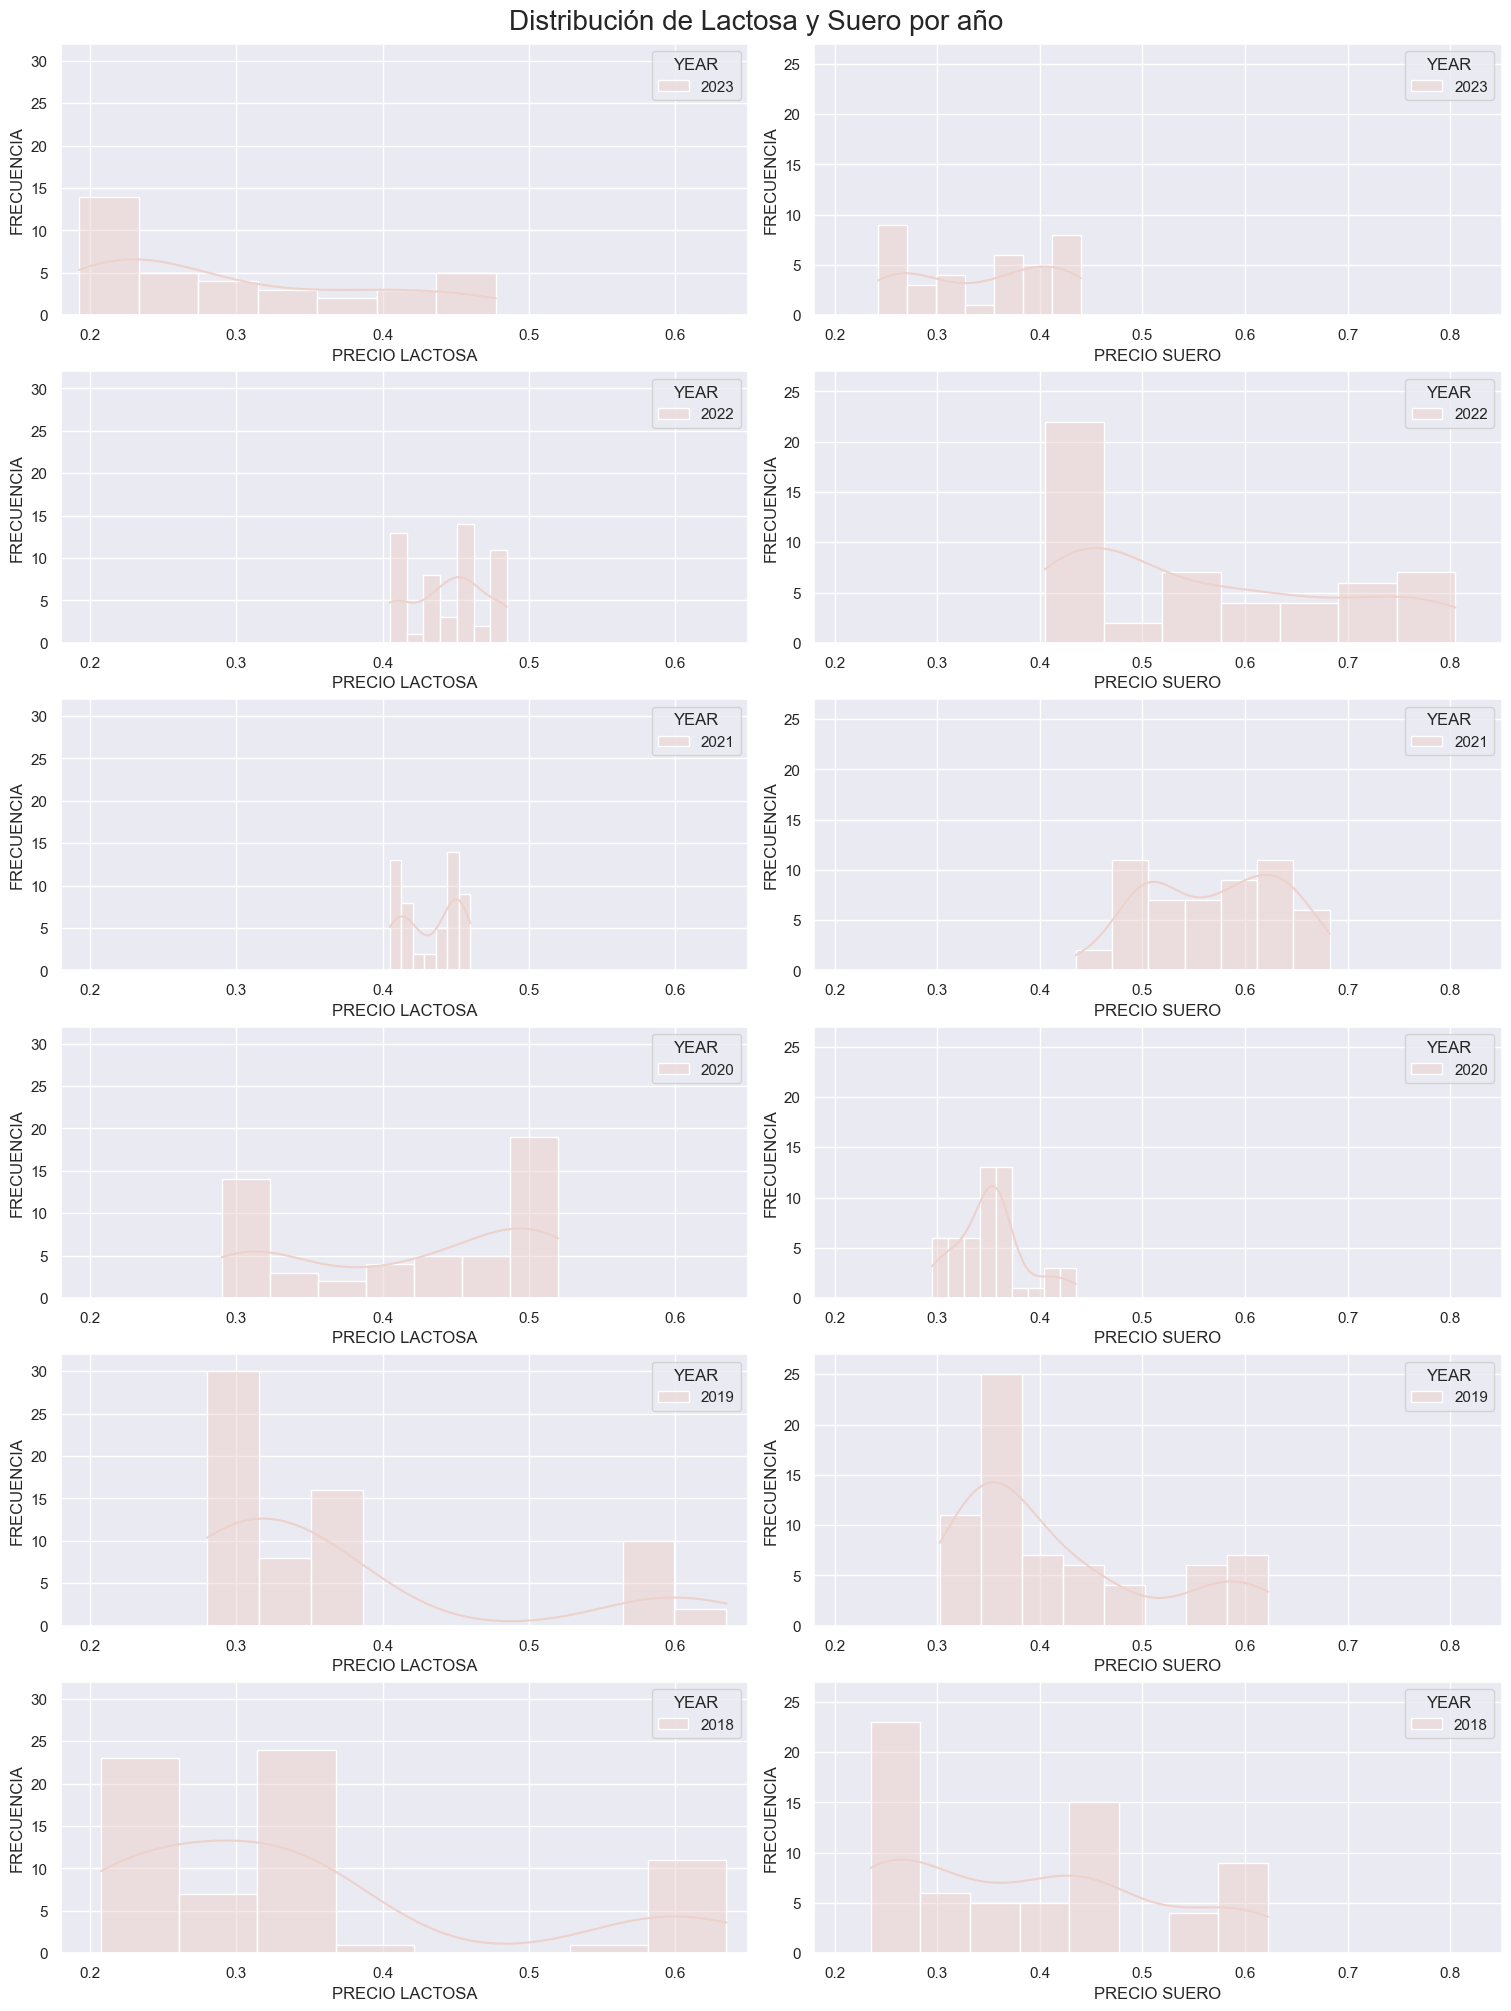

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20), layout="constrained")
fig.suptitle("Distribución de Lactosa y Suero por año", fontsize=20)

for idx, ax in enumerate(axes):
    year_data = clean_data[clean_data["YEAR"] == 2023-idx]
   
    sns.histplot(data=year_data, x="LACTOSE", hue="YEAR", kde=True, ax=ax[0])
    sns.histplot(data=year_data, x="WHEY", hue="YEAR", kde=True, ax=ax[1])
    
    ax[0].set_ylim(0, 32), ax[0].set_xlim(0.18, 0.65)
    ax[0].set_ylabel("FRECUENCIA"), ax[0].set_xlabel("PRECIO LACTOSA")
    
    ax[1].set_ylim(0, 27), ax[1].set_xlim(0.18, 0.85)
    ax[1].set_ylabel("FRECUENCIA"), ax[1].set_xlabel("PRECIO SUERO")
    

plt.savefig(f"figures/distribuciones_precio.png", bbox_inches='tight', dpi=300)


### Variación del precio sobre el tiempo

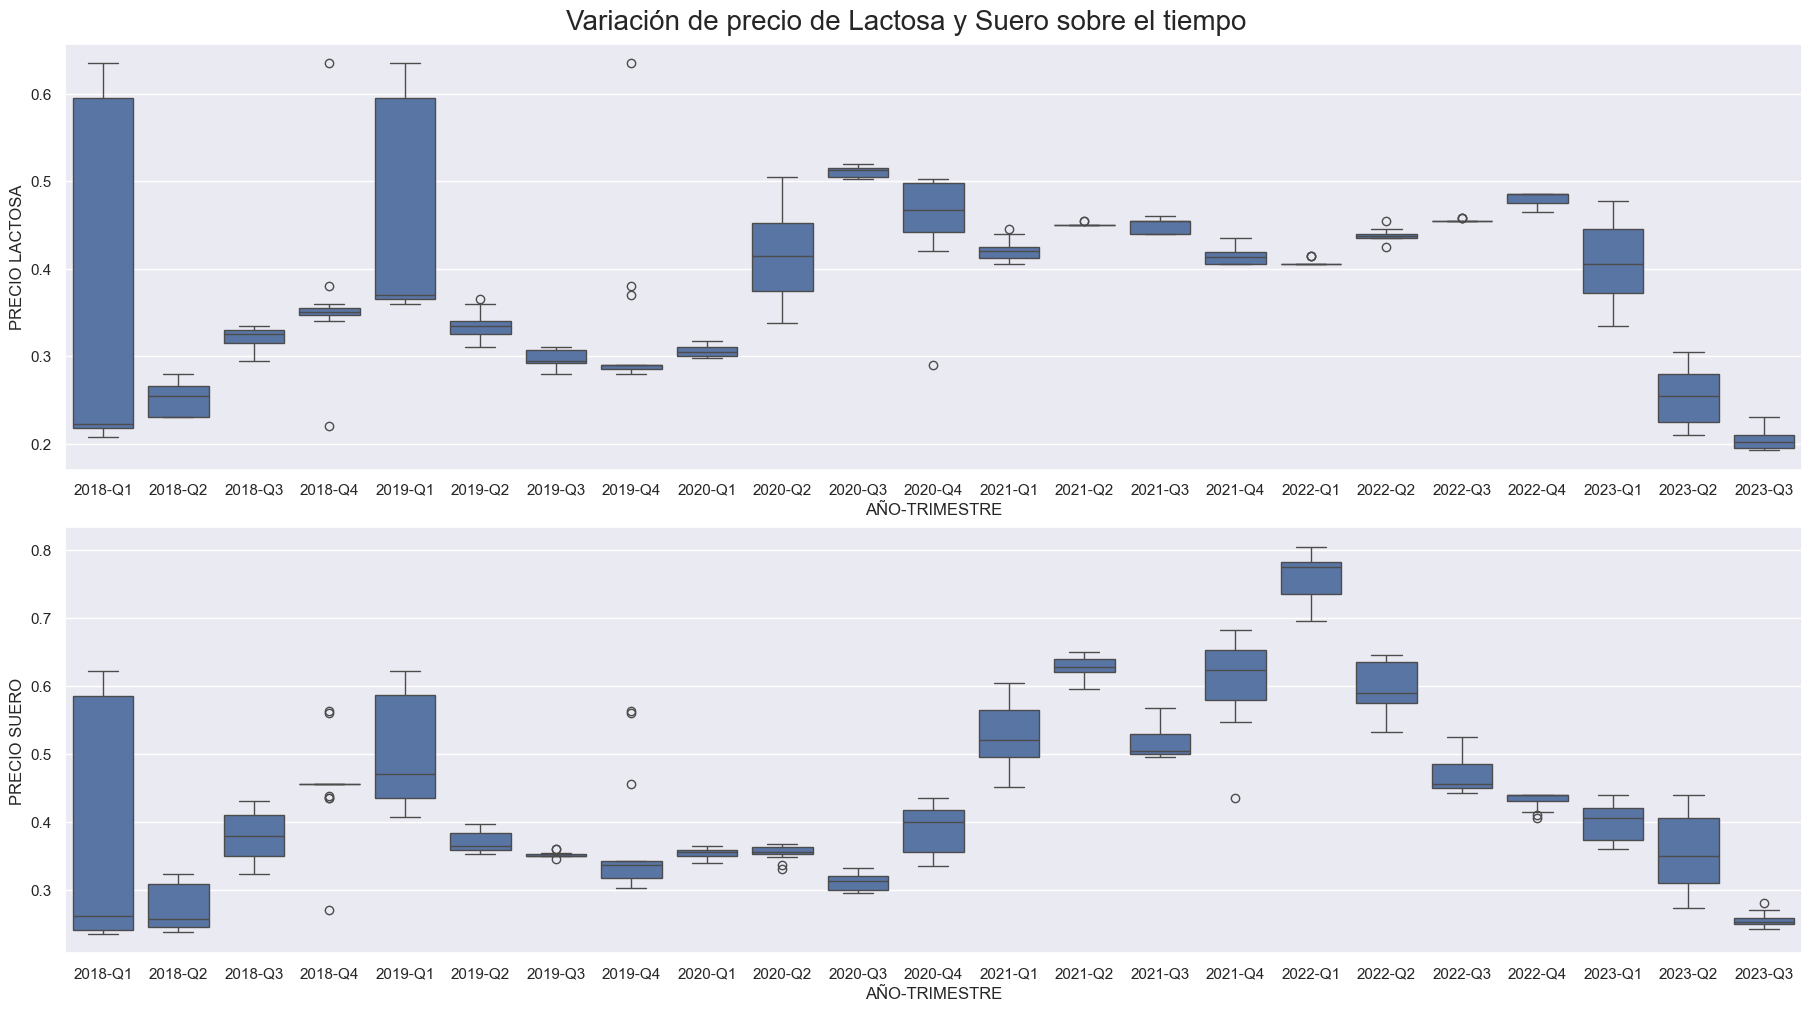

In [8]:
order = sorted(clean_data["YEAR_QUARTER"].unique())

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), layout="constrained")
fig.suptitle("Variación de precio de Lactosa y Suero sobre el tiempo", fontsize=20)

sns.boxplot(x="YEAR_QUARTER", y="LACTOSE", data=clean_data, order=order, ax=axes[0])
sns.boxplot(x="YEAR_QUARTER", y="WHEY", data=clean_data, order=order, ax=axes[1])

axes[0].set_ylabel("PRECIO LACTOSA"), axes[0].set_xlabel("AÑO-TRIMESTRE")
axes[1].set_ylabel("PRECIO SUERO"), axes[1].set_xlabel("AÑO-TRIMESTRE")

plt.savefig(f"figures/precio_tiempo.png", bbox_inches='tight', dpi=300)


## Función de costo

In [9]:
clean_data[["YEAR_QUARTER", "LACTOSE", "WHEY"]].sample(10)


,YEAR_QUARTER,LACTOSE,WHEY
61,2022-Q2,0.455,0.5325
60,2022-Q2,0.445,0.5700
82,2022-Q4,0.485,0.4400
254,2019-Q4,0.290,0.3425
63,2022-Q3,0.455,0.5250
53,2022-Q2,0.435,0.6300
18,2023-Q2,0.255,0.3775
59,2022-Q2,0.440,0.5700
126,2021-Q3,0.440,0.5100
52,2022-Q2,0.435,0.6350


Se necesita determinar un modelo de precio que maximice las ganancias, el cuál está establecido por
$$R(p) = pD(p)$$
Donde:
- $R(P)$ es la ganancia
- $p$ es el precio del producto
- $D(p)$ la demanda del producto al precio $p$

Además, $D(p)$ se establece como
$$D(p) = a - bp$$
Donde $a$ y $b$ son parámetros de nuestro modelo

### Datos sintéticos de inventario

Para facilitar el análisis, se generan datos sintéticos de inventario, y se asume que durante las ventas fueron totales, es decir, la demanda fue igual a inventario

In [10]:
def fit_stock(stock: int):
    if stock < 2000:
        return 2000
    if stock > 10000:
        return 10000
    return stock


In [40]:
stock_lactose = np.random.normal(loc=5000, scale=2000, size=len(clean_data)//3).astype(int)
stock_whey = np.random.normal(loc=5000, scale=1500, size=len(clean_data)//3).astype(int)
clean_data["STOCK_LACTOSE"] = np.random.choice(stock_lactose, size=len(clean_data))
clean_data["STOCK_WHEY"] = np.random.choice(stock_whey, size=len(clean_data))
clean_data["STOCK_LACTOSE"] = clean_data["STOCK_LACTOSE"].transform(fit_stock)
clean_data["STOCK_WHEY"] = clean_data["STOCK_WHEY"].transform(fit_stock)
clean_data[["LACTOSE", "STOCK_LACTOSE", "WHEY", "STOCK_WHEY"]].sample(10)


,LACTOSE,STOCK_LACTOSE,WHEY,STOCK_WHEY
76,0.4650,5703,0.44000,5395
229,0.3150,3888,0.35500,7513
271,0.3800,3888,0.56250,5683
147,0.3050,2839,0.36000,3747
304,0.3200,3952,0.37375,3275
272,0.2200,5964,0.27000,4705
85,0.4750,7033,0.41500,5086
107,0.4500,6618,0.64500,5325
152,0.3100,4818,0.35875,4210
93,0.4125,3950,0.50250,6283


### Demanda para Lactosa

In [34]:
lactose_reg = LinearRegression(positive=True).fit(clean_data[["LACTOSE"]], clean_data["STOCK_LACTOSE"])
print(f"D_l(p) = {lactose_reg.intercept_:.4f} - {lactose_reg.coef_[0]:.4f}p ")
l_i, l_c = lactose_reg.intercept_, lactose_reg.coef_[0]

def demand_lactose(price: float):
    return l_i - l_c*price


D_l(p) = 4514.5174 - 919.4325p 


$$D_{lactosa}(p)=4514.5174 - 919.4325p$$

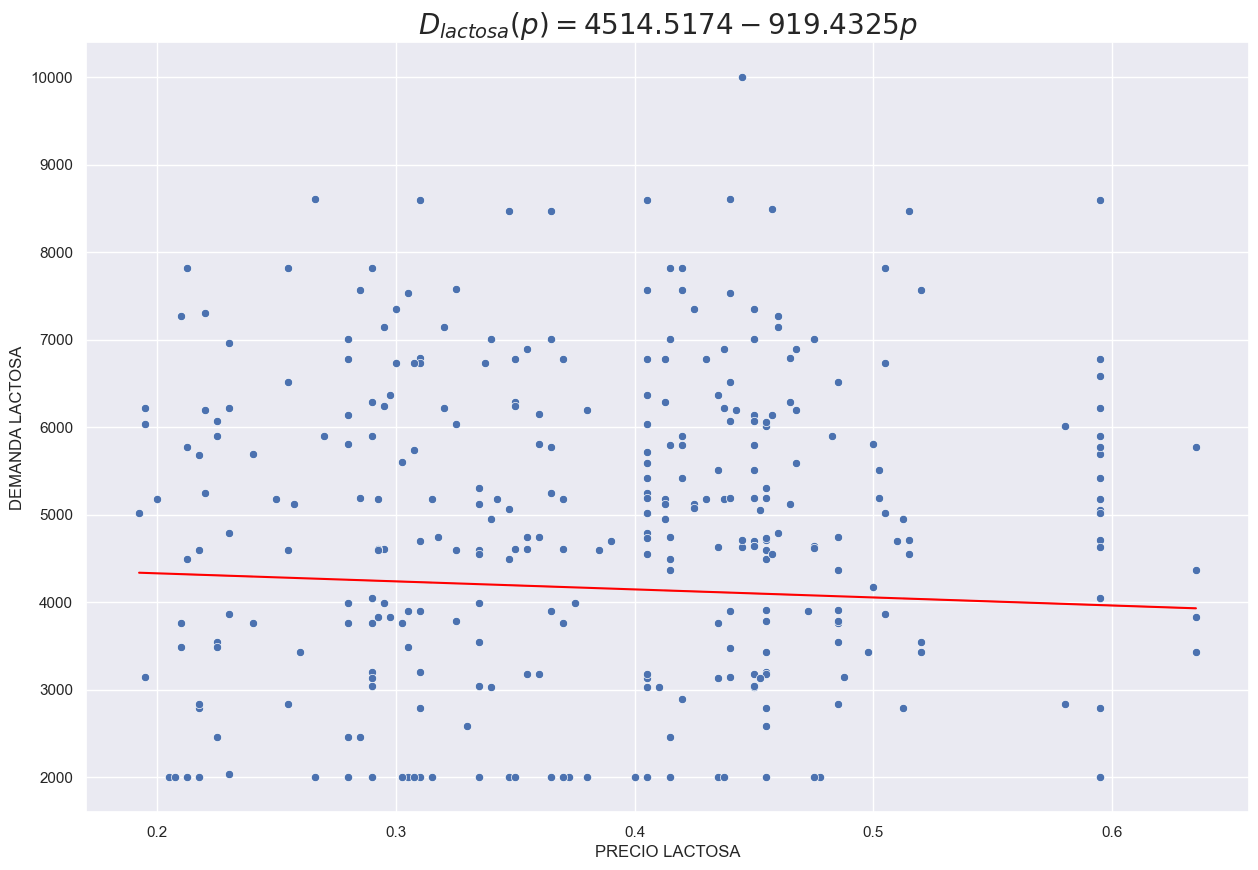

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("$D_{lactosa}(p)=4514.5174 - 919.4325p$", fontsize=20)
sns.scatterplot(data=clean_data, x="LACTOSE", y="STOCK_LACTOSE", ax=ax)
sns.lineplot(x=clean_data["LACTOSE"], y=demand_lactose(clean_data["LACTOSE"]), color="red", ax=ax)
ax.set_xlabel("PRECIO LACTOSA"), ax.set_ylabel("DEMANDA LACTOSA")
plt.savefig(f"figures/demanda_lactosa.png", bbox_inches='tight', dpi=300)


### Demanda para Suero

In [36]:
whey_reg = LinearRegression(positive=True).fit(clean_data[["WHEY"]], clean_data["STOCK_WHEY"])
print(f"D_l(p) = {whey_reg.intercept_:.4f} - {whey_reg.coef_[0]:.4f}p ")
w_i, w_c = whey_reg.intercept_, whey_reg.coef_[0]

def demand_whey(price: float):
    return w_i - w_c*price


D_l(p) = 4809.4185 - 633.3979p 


$$D_{suero}(p)=4809.4185 - 633.3979p$$

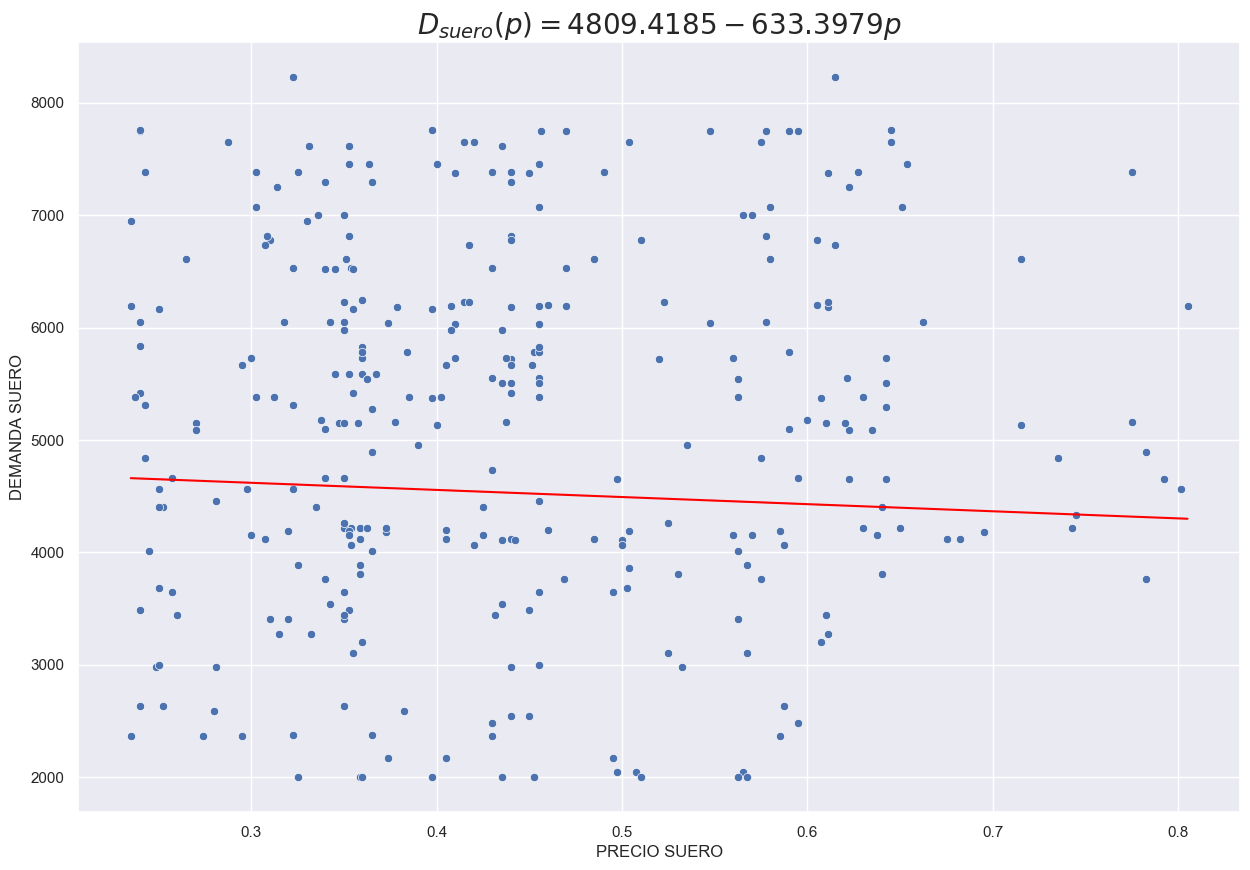

In [39]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("$D_{suero}(p)=4809.4185 - 633.3979p$", fontsize=20)
sns.scatterplot(data=clean_data, x="WHEY", y="STOCK_WHEY", ax=ax)
sns.lineplot(x=clean_data["WHEY"], y=demand_whey(clean_data["WHEY"]), color="red", ax=ax)
ax.set_xlabel("PRECIO SUERO"), ax.set_ylabel("DEMANDA SUERO")
plt.savefig(f"figures/demanda_suero.png", bbox_inches='tight', dpi=300)


### Funciones de costo finales

In [41]:
def revenue_lactose(price: float):
    return price * demand_lactose(price)

def revenue_whey(price: float):
    return price * demand_whey(price)


$$R_{lactose}=p*(4514.5174 - 919.4325p)$$
$$R_{whey}=p*(4809.4185 - 633.3979p)$$
